# Preprocessing and analysis of cfDNA data 

With 2024 Hou paper used as reference

In [ ]:
import pandas as pd
import sys
import subprocess
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import pybedtools
# from pybedtools import BedTool
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


The files used in this notebook are:

<!-- - **bileduct_subsample.bed** - bile duct cancer frag file subsampled to 50k rows (FinaleDB, Crisitano dataset)
- **bileduct_autosomes_chr.bed** - full bile duct cancer frag file
- **openchrom_200bp.bed** - open chromatin regions (DNAseq - E029,E032,E034 and ATACseq reqions for pancancer) merged to a single file, supposed to be around 560k row, but TODO currently at around 800k. Filtered to only use autosomes and with added a 'chr' prefix to the chromosome name column.
- **openchrom_with_id.bed** - open chromatin regions with unique ids
- **fragments_centroids.bed** - fragment file with start and end replaced with centroid coordinates -->
- **frag_centroids_openchrom_intersect.bed** - fragment file with with centroid coordinates intersected with openchrom regions
- **frag_ends_openchrom_intersect.bed** - fragment 5' and 3' ends intersected with openchrom regions - every fragment end which is in a given openchrom region
- **tss_150_50.bed** and **tss_1000_1000.bed** - bed files of flanking regions, created for comparison (as mentioned in the paper)

All sources linked in the protocol.txt file

In [ ]:
# fragments_path = './data/subsampled/bileduct_subsample.bed'
# fragments_path = './data/fullsample/bileduct_autosomes_chr.bed'
# openchrom_path = './data/processing/openchrom_200bp.bed'
# openchrom_path = './data/processing/openchrom_with_id.bed'
# fragments_centroids_path = './data/processing/fragments_centroids.bed'
frag_centroids_openchrom_intersect_path = './data/processing/frag_centroids_openchrom_intersect.bed'
frag_ends_openchrom_intersect_path = './data/processing/frag_ends_openchrom_intersect.bed'
tss_150_50_path = './data/processing/tss_150_50.bed'
tss_1000_1000_path = './data/processing/tss_1000_1000.bed'

#### **Load frag file** (old)

In [4]:
# fragments_centroids = pd.read_csv(fragments_centroids_path, sep="\t",
#                                     names=["chrom", "centroid1", "centroid2", "f_start", "f_end", "score", "strand"])
# print(fragments_centroids.shape)
# fragments_centroids.head()

#### **Load open chromatin region union file**

In [23]:
openchrom = pd.read_csv(
    openchrom_path,
    sep="\t",
    header=None,
    names=["oc_chrom", "oc_start", "oc_end", "region_id"]
)
print(openchrom.shape)
# openchrom['oc_chrom'].value_counts()


(838928, 4)


#### **Load fragments whose centroids fell within openchrom regions:**


In [24]:
frag_centroids_openchrom_intersect = pd.read_csv(
    frag_centroids_openchrom_intersect_path,
    sep="\t",
    header=None,
    names=["f_chrom", "centroid1", "centroid2", "f_start", "f_end", "score", "strand", "oc_chrom", "oc_start", "oc_end", "region_id"]
)
print(frag_centroids_openchrom_intersect.shape)
# frag_centroids_openchrom_intersect.head()

(2468009, 11)


#### **Load fragment ends intersection**

file to be used to compute the features 'end' and 'OCF'

this file contains 1bp bins for each fragment end, and end_type denotes whether its the smaller (U - f_start) or larger (D - f_end) boundary of a fragment


In [25]:
frag_ends_openchrom_intersect = pd.read_csv(
    frag_ends_openchrom_intersect_path,
    sep="\t",
    header=None,
    names=["f_chrom", "end1", "end2", "end_type", "oc_chrom", "oc_start", "oc_end", "region_id"]
)
print(frag_ends_openchrom_intersect.shape)
frag_ends_openchrom_intersect.head()

(4882118, 8)


,f_chrom,end1,end2,end_type,oc_chrom,oc_start,oc_end,region_id
0,chr1,10197,10198,D,chr1,10194,10394,0
1,chr1,10198,10199,D,chr1,10194,10394,0
2,chr1,10245,10246,D,chr1,10194,10394,0
3,chr1,10211,10212,D,chr1,10194,10394,0
4,chr1,10221,10222,D,chr1,10194,10394,0


#### **Create intersection using bedtools** (old)

(using the subprocess library because couldnt get pybedtools to work)

https://bedtools.readthedocs.io/en/latest/content/tools/intersect.html

In [7]:
# # run only once
# subprocess.run(f"bedtools intersect -a {fragments_path} -b {openchrom_path} -wa > data/subsampled/fragments_in_openchrom.bed", shell=True)

# # # load results
# df_fragments_in_openchrom = pd.read_csv("./data/subsampled/fragments_in_openchrom.bed", sep="\t", header=None,
#                  names=["chrom","start","end","score","strand"])

#### **Updated version** (old)

In [8]:
# # TODO create centroid column, will use it to select fragments whose centroids fell within open chromatin regions
# df = pd.read_csv(fragments_path, sep="\t", names=["chrom", "start", "end", "score", "strand"])

# df["centroid"] = ((df["start"] + df["end"]) // 2).astype(int)
# # bedtools expects start less than end?
# df_centroid = df[["chrom", "centroid", "centroid"]]  

# centroids_path = "./data/subsampled/fragments_centroids.bed"
# df_centroid.to_csv(centroids_path, sep="\t", header=False, index=False)

In [9]:
# # intersect the fragment centroid file with the 200bp openchrom regions
# centroids_in_openchrom_path = "./data/subsampled/fragments_centroids_in_openchrom.bed"
# subprocess.run(f"bedtools intersect -a {centroids_path} -b {openchrom_path} -wa > {centroids_in_openchrom_path}", shell=True)

In [10]:
# centroids_in_openchrom = pd.read_csv(centroids_in_openchrom_path, sep="\t",
#                            names=["chrom", "centroid", "centroid2"])

# df_in_open = df[df["centroid"].isin(centroids_in_openchrom["centroid"])]
# print(df_in_open.shape)
# df_in_open.head()

#### **Updated version 2** (old)
- **we need to identify which region it intersected with**

In [11]:
# # TODO create centroid column, will use it to select fragments whose centroids fell within open chromatin regions
# df_fragments = pd.read_csv(fragments_path, sep="\t", names=["chrom", "f_start", "f_end", "score", "strand"])

# df_fragments["centroid"] = ((df_fragments["f_start"] + df_fragments["f_end"]) // 2).astype(int)
# # bedtools expects start less than end?
# df_centroid = df_fragments[["chrom", "centroid", "centroid"]]  

# centroids_path = "./data/processing/fragments_centroids.bed"
# df_centroid.to_csv(centroids_path, sep="\t", header=False, index=False)

In [12]:
# intersect the fragment centroid file with the 200bp openchrom regions
# centroids_with_regions_path = "./data/processing/centroids_with_regions.bed"
# subprocess.run(f"bedtools intersect -a {centroids_path} -b {openchrom_path} -wa -wb > {centroids_with_regions_path}", shell=True)

In [13]:
# centroids_with_regions = pd.read_csv(centroids_with_regions_path, sep="\t",
#                            names=["f_chrom", "centroid1", "centroid2", "oc_chrom", "oc_start", "oc_end"])
# openchrom = pd.read_csv(openchrom_path, sep="\t", 
#                         names=["oc_chrom", "oc_start", "oc_end"])
# # openchrom["region_id"] = openchrom.index
# subprocess.run("awk 'BEGIN{OFS="\t"}' '{print $0, NR-1}' openchrom.bed > openchrom_with_id.bed", shell=True)
# openchrom = pd.read_csv("./data/processing/openchrom_with_id.bed", sep="\t",
#                         names=["oc_chrom", "oc_start", "oc_end", "region_id"])

# region_id_map = {
#     (row.oc_chrom, row.oc_start, row.oc_end): row.region_id
#     for row in openchrom.itertuples(index=False)
# }
# centroids_with_regions["region_id"] = centroids_with_regions.apply(
#     lambda row: region_id_map[(row["oc_chrom"], row["oc_start"], row["oc_end"])],
#     axis=1
# )
# centroids_with_regions.head()
# centroids_with_regions = centroids_with_regions.merge(
#     df_fragments,
#     left_on=["f_chrom", "centroid1", "centroid2"],
#     right_on=["chrom", "centroid", "centroid"],
#     how="left"
# )
# centroids_with_regions = centroids_with_regions[[
#     "f_chrom", "centroid", "f_start", "f_end", "oc_chrom", "oc_start", "oc_end",
#      "score", "strand", "region_id"
# ]]
# print("openchrom:")
# print(openchrom.shape)
# display(openchrom.head())
# print("centroids_with_regions:")
# print(centroids_with_regions.shape)
# centroids_with_regions.head()



Now we have created a dataframe of fragments whose centroids lie within the 200bp openchrom windows, with **each region having a unique id.**
This resulted in 2831 fragments for our 50000 subsample.

### LENGTH
2024 Hou et.al. Experimental section:

'For each autosome, fragments shorter than 300 bp were
divided into 30 categories at 10 bp intervals, whereas those longer than
300 bp were grouped into a single category. Consequently, a feature vector
of length 31 × 22 was generated for each sample.'

$
    \textcolor{red}{TODO} - 
$
sort by number

/tmp/ipykernel_908/3090103392.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["f_chrom", "len_bin"])


shape of feature matrix: (22, 31)


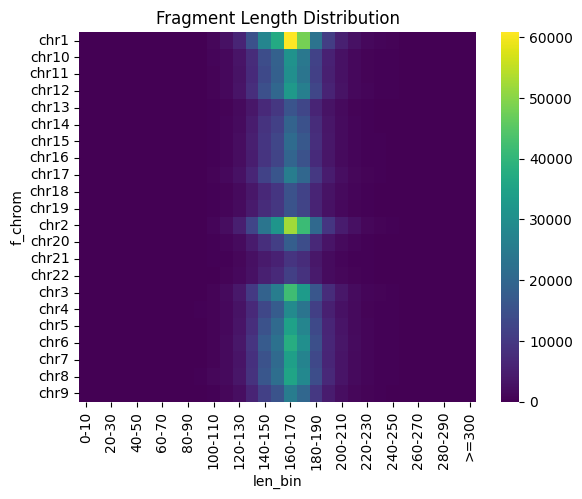

In [26]:
bin_edges = list(range(0, 310, 10)) + [np.inf] 
# print(bin_edges)
bin_labels = [f"{i}-{i+10}" for i in range(0, 300, 10)] + [">=300"]

# fragment lengths
frag_centroids_openchrom_intersect["length"] = frag_centroids_openchrom_intersect["f_end"] - frag_centroids_openchrom_intersect["f_start"]

# bin lengths
frag_centroids_openchrom_intersect["len_bin"] = pd.cut(
    frag_centroids_openchrom_intersect["length"], 
    bins=bin_edges, 
    labels=bin_labels, 
    right=False,
    include_lowest=True
)

# group by chromosome and bin and get counts
length_matrix = (
    frag_centroids_openchrom_intersect
    .groupby(["f_chrom", "len_bin"])
    .size()
    .unstack(fill_value=0)
)

# convert to proportions per chromosome
df_length = length_matrix

plt.figure()
#  sort f_chrom by number not alphabetically


sns.heatmap(df_length, cmap="viridis")
plt.title("Fragment Length Distribution")
print("shape of feature matrix:", df_length.shape)

    

### **PFE**

'after tallying the selected fragments, they were cat-
egorized as shorter than 100 bp, and longer than 250 bp, and those rang-
ing from 100–250 bp were further divided into 15 categories at 10 bp in-
tervals. Fragment proportions in each category were computed and the
entropy value for that speciﬁc region was calculated using the following
formula'

$
    \text{PFE} = -\sum_iP_i\log_2P_i 
$

where P_i is the raio of fragments in the ith category

 we selected fragments whose centroids fell within the binned openchrom regions. now **iterating over ALL the regions, we calculate PFE using only these selected fragments**.



In [27]:
# # 1 bin below 100bp
# # 15 bins 100-250bp
# # 1 bin above 250bp


bins_pfe = [0,100] + list(range(110, 260, 10)) + [np.inf]
bin_labels_pfe = [f"{bins_pfe[i]}-{bins_pfe[i+1]}" for i in range(len(bins_pfe)-1)]


# create length column for later binning
frag_centroids_openchrom_intersect["length"] = (
    frag_centroids_openchrom_intersect["f_end"] -
    frag_centroids_openchrom_intersect["f_start"]
)

/tmp/ipykernel_908/3146236727.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["region_id", "pfe_bin"])


SHAPE of pfe: (767381, 1)


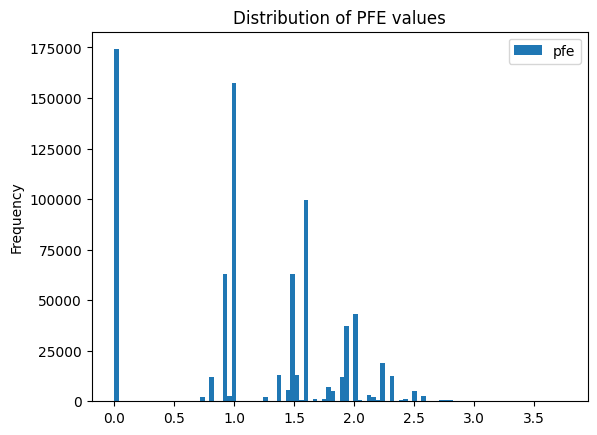

In [37]:
# cut into categories
frag_centroids_openchrom_intersect["pfe_bin"] = pd.cut(
    frag_centroids_openchrom_intersect["length"],
    bins=bins_pfe,
    labels=bin_labels_pfe,
    right=False,
    include_lowest=True
)

# calculate P_i
counts = (
    frag_centroids_openchrom_intersect
    .groupby(["region_id", "pfe_bin"])
    .size()
    .unstack(fill_value=0)
)
pfe_proportions = counts.div(counts.sum(axis=1), axis=0)
pfe_proportions.replace(0, np.nan, inplace=True)

# get actual PFE per refion
pfe = - (pfe_proportions * np.log2(pfe_proportions)).sum(axis=1)
df_pfe = pd.DataFrame(pfe, columns=["pfe"]).reset_index(drop=True)
df_pfe.plot(kind='hist', bins=100, title='Distribution of PFE values')
print("SHAPE of pfe:", df_pfe.shape)
# display(df_pfe.head())

shape mismatch - 767381 vs 838928, likely due to the nonzero condition

### **FSR**

'selected fragments were tallied and divided into
3 categories based on their lengths: short (65–150 bp), medium (151–
220 bp), and long (221–400 bp). The fragment proportion in each category
was calculated and each sample had 561414 × 3 features.'

In [29]:
# i havent confirmed this but i am guessing that 65 is the shortest and 400 is the longest recorded in the dataset, otherwise we would leave out multiple fragments
# 1 bin 65-150bp
# 1 bin 151-220bp
# 1 bin above 221-400bp

bins_fsr = [65, 151, 221, 400]
bin_labels_fsr = [f"{bins_fsr[i]}-{bins_fsr[i+1]}" for i in range(len(bins_fsr)-1)]

frag_centroids_openchrom_intersect["fsr_bin"] = pd.cut(
    frag_centroids_openchrom_intersect["length"],
    bins=bins_fsr,
    labels=bin_labels_fsr,
    right=False,
    include_lowest=True
)
frag_centroids_openchrom_intersect_grouped = frag_centroids_openchrom_intersect.groupby("region_id")

counts = (
    frag_centroids_openchrom_intersect
    .groupby(["region_id", "fsr_bin"])
    .size()
    .unstack(fill_value=0)
)
df_fsr = counts.div(counts.sum(axis=1), axis=0)


print(df_fsr.shape)
display(df_fsr.head())
df_fsr.describe()


/tmp/ipykernel_908/292248624.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["region_id", "fsr_bin"])


(767381, 3)


fsr_bin,65-151,151-221,221-400
region_id,,,
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.5,0.5,0.0


fsr_bin,65-151,151-221,221-400
count,767381.000000,767381.000000,767381.000000
mean,0.228035,0.761427,0.010537
std,0.283215,0.287689,0.068991
min,0.000000,0.000000,0.000000
25%,0.000000,0.600000,0.000000
50%,0.142857,0.833333,0.000000
75%,0.375000,1.000000,0.000000
max,1.000000,1.000000,1.000000


### FSD

"all selected fragments were tallied. Those with
lengths ranging from 65 to 400 bp were divided into 67 categories at 5 bp
intervals, and the fragment proportions in each category were calculated.
Therefore, each sample contained 67 × 22 features"

/tmp/ipykernel_908/2885575559.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["f_chrom", "fsd_bin"])


(22, 67)


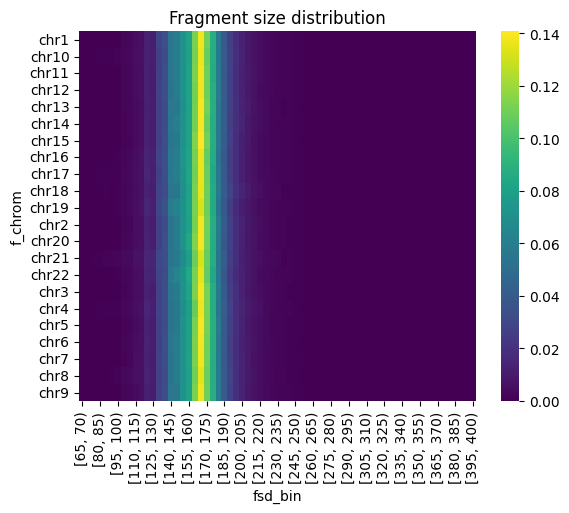

In [30]:
bins_fsd = list(range(65, 405, 5)) 

frag_centroids_openchrom_intersect["fsd_bin"] = pd.cut(
    frag_centroids_openchrom_intersect["length"],
    bins=bins_fsd,
    right=False,
    include_lowest=True
)

counts = (
    frag_centroids_openchrom_intersect
    .groupby(["f_chrom", "fsd_bin"])
    .size()
    .unstack(fill_value=0)
)

df_fsd = counts.div(counts.sum(axis=1), axis=0)

print(df_fsd.shape)
# df_fsd.head()
plt.figure()
sns.heatmap(df_fsd, cmap="viridis")
plt.title("Fragment size distribution")
plt.show()


In [31]:
frag_centroids_openchrom_intersect.head()

,f_chrom,centroid1,centroid2,f_start,f_end,score,strand,oc_chrom,oc_start,oc_end,region_id,length,len_bin,pfe_bin,fsr_bin,fsd_bin
0,chr1,10242,10242,10182,10302,4,+,chr1,10194,10394,0,120,120-130,120-130,65-151,"[120, 125)"
1,chr1,10387,10387,10342,10433,0,-,chr1,10194,10394,0,91,90-100,0-100,65-151,"[90, 95)"
2,chr1,17527,17527,17447,17608,40,+,chr1,17388,17588,1,161,160-170,160-170,151-221,"[160, 165)"
3,chr1,96573,96573,96485,96662,27,-,chr1,96514,96714,2,177,170-180,170-180,151-221,"[175, 180)"
4,chr1,103054,103054,102970,103139,20,-,chr1,102859,103059,3,169,160-170,160-170,151-221,"[165, 170)"


### coverage

"selected fragments were tallied. For each
sample, the features consisted of a vector of size 561414 × 1 (for subsequent
fragmentation patterns, the number of features for each sample was
561414 × 1 unless otherwise specified)."

In [ ]:
frag_centroids_openchrom_intersect_grouped = frag_centroids_openchrom_intersect.groupby("region_id")
print("number of regions:", len(frag_centroids_openchrom_intersect_grouped))

# size of each group for each region
df_cov = pd.DataFrame(frag_centroids_openchrom_intersect_grouped.size()).rename(columns={0: "coverage"}).reset_index(drop=True)
print("shape:", df_cov.shape)
df_cov.head()
df_cov.describe()

number of regions: 767381
shape: (767381, 1)


,coverage
count,767381.000000
mean,3.216146
std,6.817684
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,3458.000000


### end

"the number of fragment ends within each open
chromatin region was counted."

In [36]:
# TODO frag ends has more regions than frag centroids
counts = (
    frag_ends_openchrom_intersect
    .groupby("region_id")
    .size()
)
df_end = pd.DataFrame(counts).rename(columns={0: "end"}).reset_index(drop=True)
print("shape of fragment ends counts:", df_end.shape)
display(df_end.head())
df_end.describe()

shape of fragment ends counts: (820328, 1)


,end
0,23
1,5
2,2
3,5
4,4


,end
count,820328.000000
mean,5.951422
std,10.062547
min,1.000000
25%,4.000000
50%,6.000000
75%,8.000000
max,5011.000000


###  OCF

"coordinates of the position with the smaller fragment
genome (U) and that with the larger fragment genome (D) on each
chromosome were determined with the corresponding counts. For each
open chromatin region, a 20 bp range was selected based on a 60 bp shift
upstream and downstream of the centroid. The OCF of the region was
calculated using the following equation:"

$
\mathrm{OCF} = - \sum_{-60-10}^{-60+10} (D - U) \;+\; \sum_{60-10}^{60+10} (U - D)
$

### IFS

"the fragments (n) within each open chromatin region including
the fragment centroid were counted and their average length (l)
within the region was calculated. L represents the average fragment length
of the whole chromosome. The calculation formula is as follows:"

$

$

### WPS

"according to the genomic coordinate position of each
cfDNA fragment, a window of 120 bp was slid at 1 bp intervals, and the
likelihood of each base pair being covered at the whole genome level, fully
covered (+1), and partially covered (−1), was counted. The mean value of
all loci within each open chromatin region was calculated."

### EDM

"the EDM consisting of 4 bases at the 5′ end of the cfDNA
fragment whose fragment centroid was within the open chromatin region
was viewed. The proportion of each EDM on each chromosome was
counted separately. Therefore, for each sample, the feature had a vector of
size 256 × 22."